In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel


In [2]:
npart=4
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.ToyJetDataset(npart,nj_train,nj_valid,nj_testy)

xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 0
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent : 1000
xevent : 2000
xevent : 3000
xevent : 4000
xevent : 5000
xevent : 6000
xevent : 7000
xevent : 8000
xevent : 9000
xevent : 0
xevent :

In [19]:
input_dim  = tjds.train_data.shape[1]
hidden_dims= [64,64,32,16]
embed_dim  = 2
temp = 0.5
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


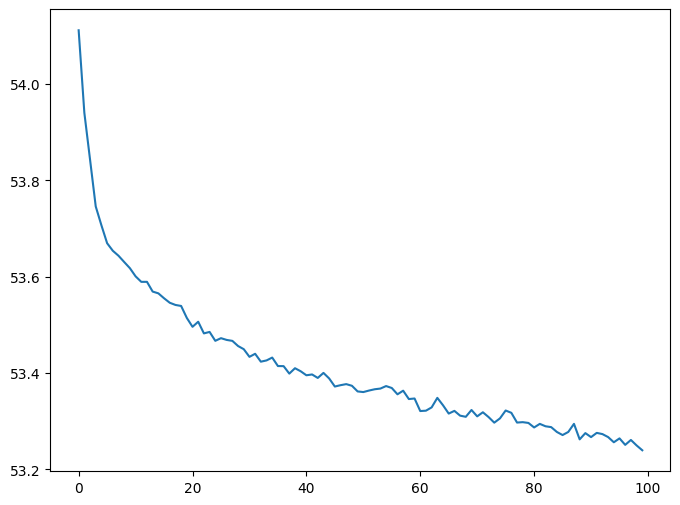

In [21]:
# Training loop
num_epochs = 100
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)

def train_generic(inepochs,itrainloader,imodel,icriterion,ioptimizer):
    losses = []
    for epoch in tqdm(range(inepochs)):
        imodel.train()
        epoch_loss = []
        for batch_data, labels in itrainloader:
            batch_data = batch_data.float()

            # Potential to add any augmentation here
            features = imodel(batch_data).unsqueeze(1)
        
            # Compute SimCLR loss
            loss = icriterion(features,labels=labels)
        
            # Backward pass and optimization
            ioptimizer.zero_grad()
            loss.backward()
            ioptimizer.step()
        
            epoch_loss.append(loss.item())
        mean_loss = np.mean(epoch_loss)
        losses.append(mean_loss)
        #if epoch % 1 == 0:
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')
    
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(losses)),losses)
        
train_generic(num_epochs,trainloader,model,criterion,optimizer)

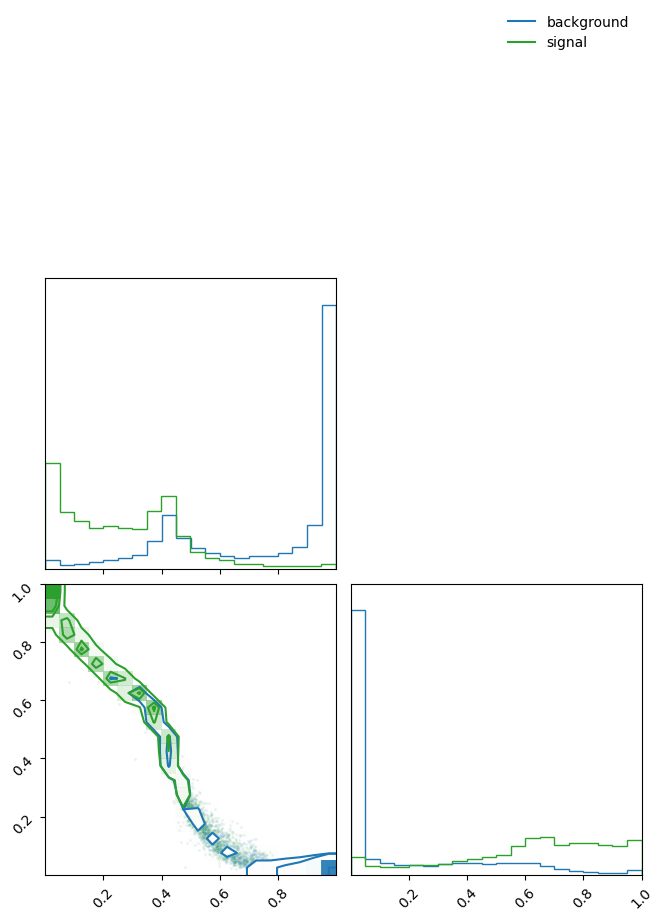

In [22]:
output = []
labels=tjds.test_labels.int()
with torch.no_grad():
    output = (model(tjds.test_data.float(),embed=True).numpy())

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C2", label='signal')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C2", label='signal'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


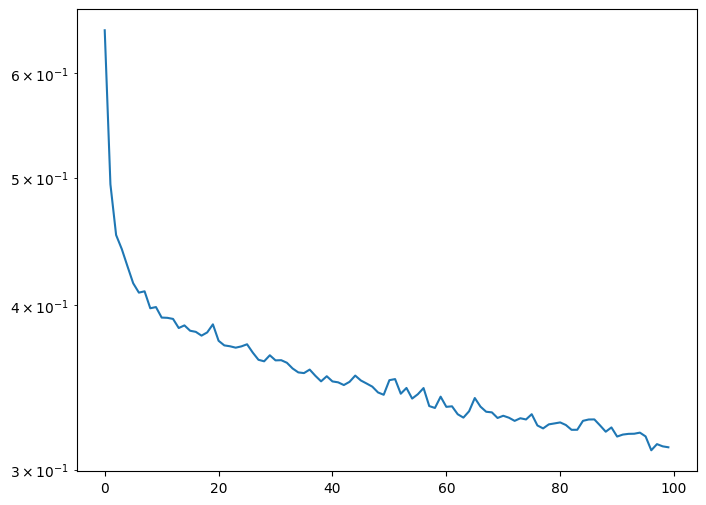

In [13]:
def train_disc(inepochs,itrain,input_dim):
    num_epochs=inepochs
    hidden_dims= [64,128,32,16]
    disc_criterion = nn.BCELoss()
    disc_model     = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,output_activation="sigmoid",dropout=0.)#.to(device)
    disc_optimizer = torch.optim.AdamW(disc_model.parameters(), lr=0.5e-2)
    losses = []
    for epoch in tqdm(range(num_epochs)):
        disc_model.train()
        epoch_loss = []
        for batch_data, labels in itrain:
            batch_data = batch_data.float()
            features = disc_model(batch_data).unsqueeze(1)
            loss = disc_criterion(features.flatten(),labels.flatten())
            disc_optimizer.zero_grad()
            loss.backward()
            disc_optimizer.step()        
            epoch_loss.append(loss.item())
        mean_loss = np.mean(epoch_loss)
        losses.append(mean_loss)
    #if epoch % 10 == 0:
    #    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss:.4f}')
    
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(losses)),losses)
    plt.yscale('log')
    return disc_model

batch_size=1000
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model=train_disc(100,trainloader,input_dim)


Accuracy: tensor(0.7955)


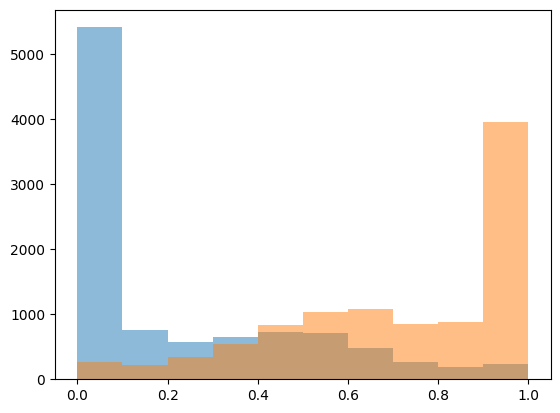

In [14]:
from torchmetrics import Accuracy
def check_disc(itest_data,itest_labels,imodel):
    test_accuracy = Accuracy(task="binary", num_classes=2)
    output = []
    labels=itest_labels.int()
    with torch.no_grad():
        output = (imodel(itest_data.float()))
    print("Accuracy:",test_accuracy(output.flatten(),labels.flatten()))
    _,bins,_=plt.hist(output[labels==0],alpha=0.5)
    plt.hist(output[labels==1],alpha=0.5,bins=bins)
    plt.show()

check_disc(tjds.test_data,tjds.test_labels,disc_model)

torch.Size([20000, 2]) torch.Size([20000])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


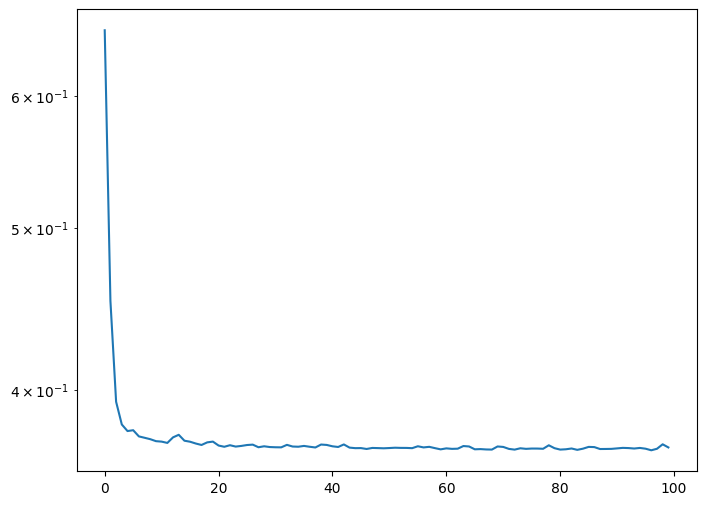

In [23]:
import data.data_utils as dutils

labels     = tjds.train_labels
test_labels= tjds.test_labels.int()
with torch.no_grad():
    output      = (model(tjds.train_data.float(),embed=True))
    output_test = (model(tjds.test_data.float(),embed=True))

print(output.shape,labels.shape)
trainspace=dutils.GenericDataset(output,labels)
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=train_disc(100,trainloader,output.shape[1])
#check_disc(output_test,test_labels,disc_model_ctr)

Accuracy: tensor(0.8001)


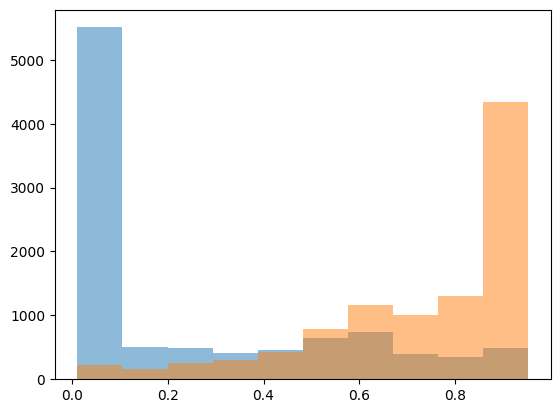

In [24]:
check_disc(output_test,test_labels,disc_model_ctr)

In [4]:
input_dim  = tjds.train_data.shape[1]
print(input_dim)
hidden_dims= [32,32,16,16]
embed_dim  = 2
temp = 0.1
embedder_nl   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid")#.to(device)
projector_nl  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_nl     = SimCLRModel(embedder_nl, projector_nl)
optimizer_nl = torch.optim.AdamW(model_nl.parameters(), lr=0.1e-1)

60


/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


In [5]:
def train_aug(inepochs,itrainloader,imodel,icriterion,ioptimizer):
    losses = []
    for epoch in tqdm(range(inepochs)):
        #imodel.train()
        epoch_loss = []
        for batch_data, labels in itrainloader:
            #print(labels,batch_data[0],batch_data[1])
            #batch_data = batch_data.float()
            #print(batch_data[0].shape,torch.flatten(batch_data[0],start_dim=1).shape)
            # Potential to add any augmentation here
            feat0     = imodel(torch.flatten(batch_data[0],start_dim=1)).unsqueeze(1)
            feat1     = imodel(torch.flatten(batch_data[1],start_dim=1)).unsqueeze(1)
            feat      = torch.cat((feat0,feat1),axis=1)
            #print(feat0,feat1)
            #print(feat0,feat1)
            #print(batch_data[0])
            #print(batch_data[1])
            #a
            # Compute SimCLR loss
            loss = icriterion(feat)
            #print(loss)
            #a
            # Backward pass and optimization
            ioptimizer.zero_grad()
            loss.backward()
            ioptimizer.step()
            epoch_loss.append(loss.item())
            #print(epoch_loss[-1])
        mean_loss = np.mean(epoch_loss)
        losses.append(mean_loss)

    plt.figure(figsize=(8,6))
    plt.plot(np.arange(len(losses)),losses)
    #plt.yscale('log')
               
# Training loop
num_epochs = 30
batch_size = 1000
temp = 0.1
optimizer_nl = torch.optim.AdamW(model_nl.parameters(), lr=0.1e-1)
criterion_nl = SupervisedSimCLRLoss(temperature=temp)
# Dataloaders
trainloader_aug = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
train_aug(num_epochs,trainloader_aug,model_nl,criterion_nl,optimizer_nl)

TypeError: object of type 'AugmentationDataset' has no len()

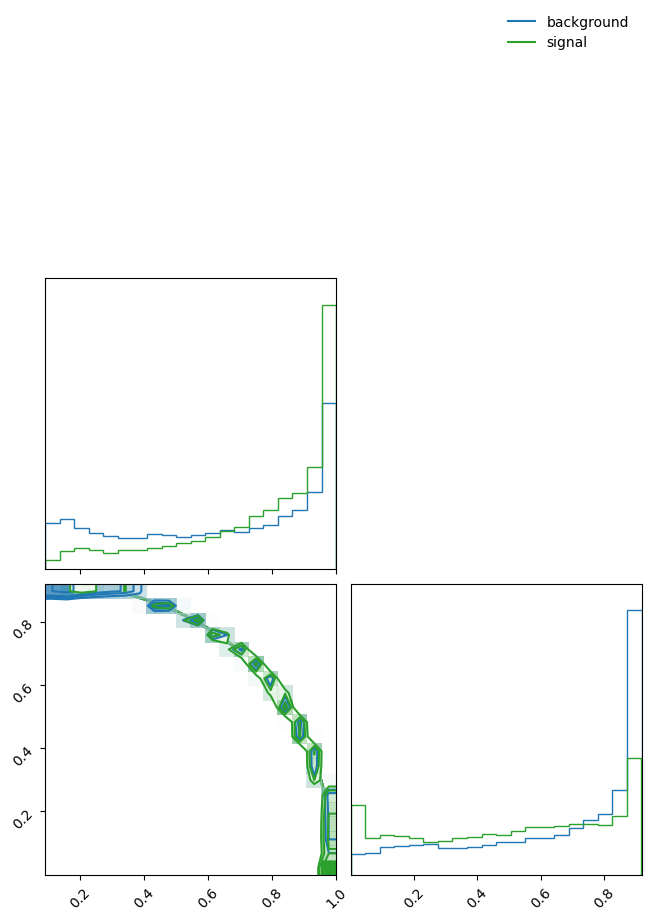

In [8]:
# output = []
labels=tjds.test_labels.int()
with torch.no_grad():
    output = (model_nl(tjds.test_data.float(),embed=True).numpy())

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C2", label='signal')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C2", label='signal'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


torch.Size([20000, 2]) torch.Size([20000])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


Accuracy: tensor(0.5964)


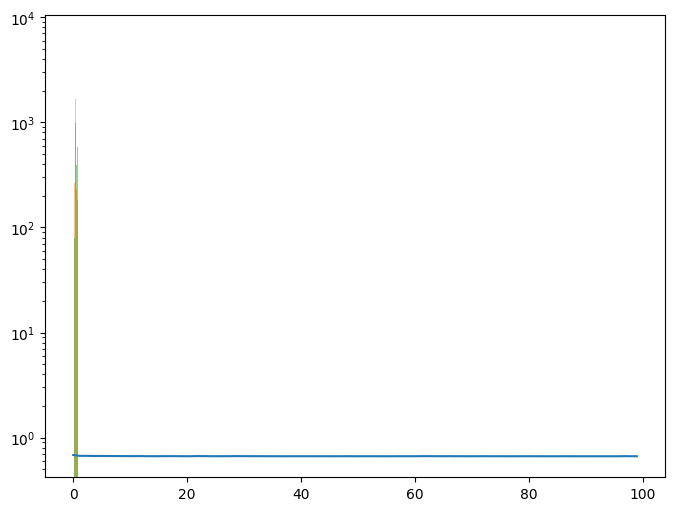

In [17]:
import data.data_utils as dutils

labels     = tjds.train_labels
test_labels= tjds.test_labels.int()
with torch.no_grad():
    output      = (model_nl(tjds.train_data.float(),embed=True))
    output_test = (model_nl(tjds.test_data.float(),embed=True))

print(output.shape,labels.shape)
trainspace=dutils.GenericDataset(output,labels)
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=train_disc(100,trainloader,output.shape[1])


Accuracy: tensor(0.5964)


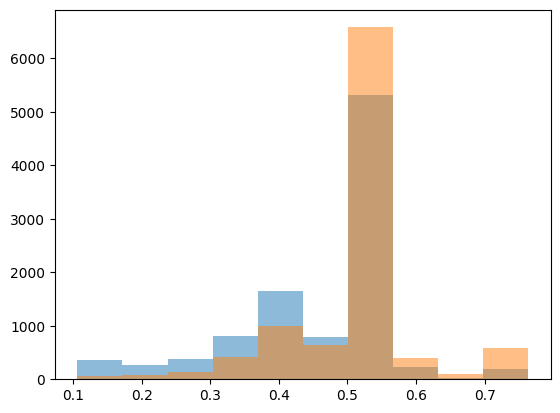

In [18]:
check_disc(output_test,test_labels,disc_model_ctr)

In [33]:
input_dim  = tjds.train_data.shape[1]
print(input_dim)
hidden_dims= [32,32,16,16]
embed_dim  = 4
temp = 0.1
embedder_nl2   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid")#.to(device)
projector_nl2  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_nl2     = SimCLRModel(embedder_nl, projector_nl)
optimizer_nl2 = torch.optim.AdamW(model_nl.parameters(), lr=0.1e-1)

12


/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [12:06<00:00, 24.22s/it]


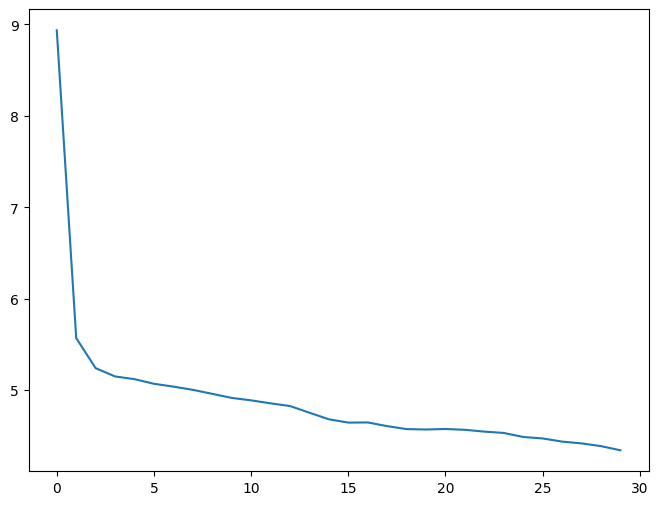

In [34]:
# Training loop
num_epochs = 30
batch_size = 1000
temp = 0.1
optimizer_nl2 = torch.optim.AdamW(model_nl2.parameters(), lr=0.1e-1)
criterion_nl2 = SupervisedSimCLRLoss(temperature=temp)
# Dataloaders
trainloader_aug = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
train_aug(num_epochs,trainloader_aug,model_nl2,criterion_nl2,optimizer_nl2)

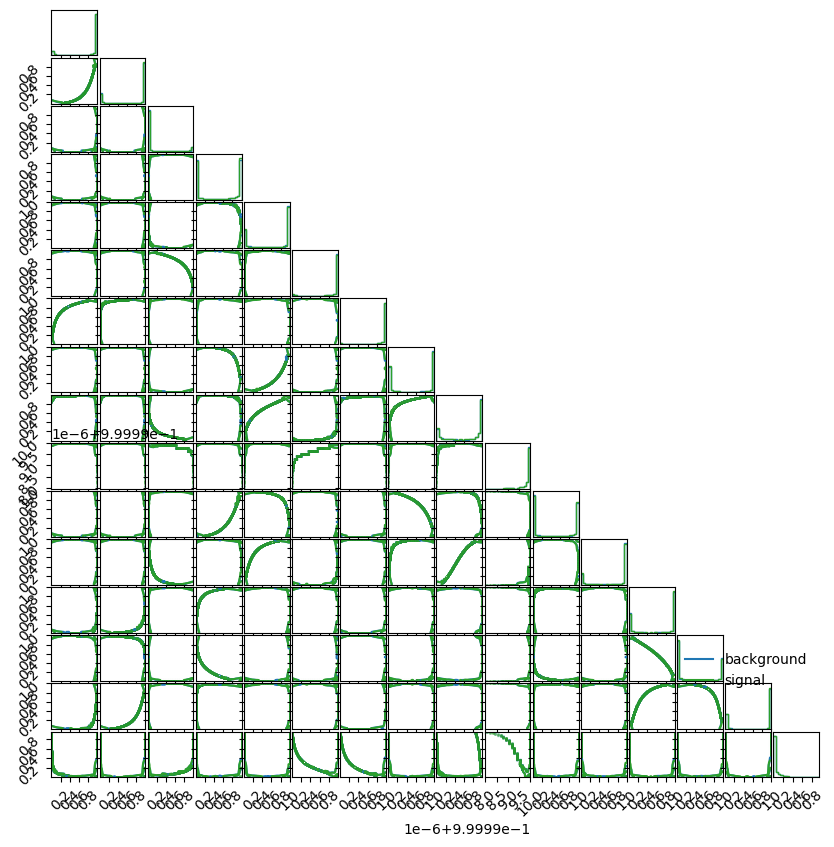

In [35]:
# output = []
labels=tjds.test_labels.int()
with torch.no_grad():
    output = (model_nl2(tjds.test_data.float(),embed=True).numpy())

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C2", label='signal')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C2", label='signal'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


torch.Size([20000, 16]) torch.Size([20000])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


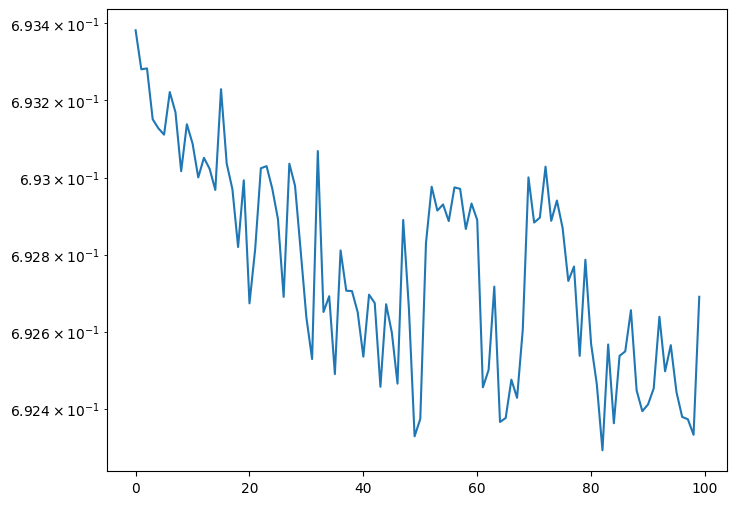

In [36]:
import data.data_utils as dutils

labels     = tjds.train_labels
test_labels= tjds.test_labels.int()
with torch.no_grad():
    output      = (model_nl2(tjds.train_data.float(),embed=True))
    output_test = (model_nl2(tjds.test_data.float(),embed=True))

print(output.shape,labels.shape)
trainspace=dutils.GenericDataset(output,labels)
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=train_disc(100,trainloader,output.shape[1])


Accuracy: tensor(0.4929)


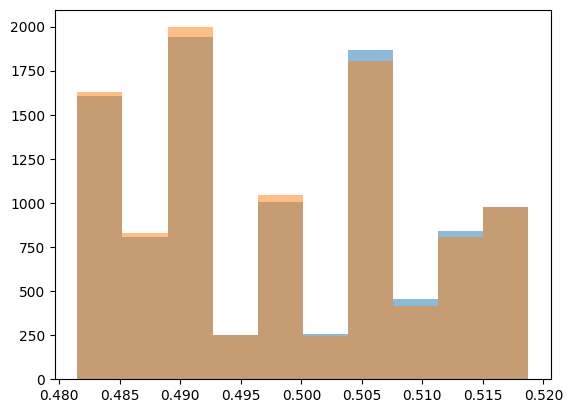

In [37]:
check_disc(output_test,test_labels,disc_model_ctr)

In [118]:
x = torch.randn(4, 3)
print(x,x.shape)
norm_last_dim = torch.linalg.norm(x, dim=-1, keepdim=True)
print(norm_last_dim) # Output: torch.Size([2, 3, 1])

tensor([[-0.5073,  0.0410, -0.7400],
        [-1.8470, -0.2636,  0.1933],
        [ 0.8260, -0.8105,  0.0870],
        [-1.0167, -0.2652, -0.8003]]) torch.Size([4, 3])
tensor([[0.8981],
        [1.8757],
        [1.1605],
        [1.3208]])


In [59]:
x=torch.tensor([[0, 1., 0],
            [0, 1., 0],
            [0, 1., 0],
            [0, 1., 0]])
print(x.shape)
norm_last_dim = torch.linalg.norm(x, dim=-1, keepdim=True)
print(norm_last_dim)

torch.Size([4, 3])
tensor([[1.],
        [1.],
        [1.],
        [1.]])


In [73]:
rot=torch.tensor([[[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]]])


In [75]:
v=torch.tensor([[ 0.4535, -0.0669,  0.0333],
        [ 0.0727,  0.0232, -0.0241],
        [ 0.1491,  0.0726, -0.0258],
        [ 0.1247, -0.0288,  0.0165]])
rot=torch.tensor([[[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]],

        [[-0.6442,  0.0000, -0.7649],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7649,  0.0000, -0.6442]]])

In [83]:
torch.matmul(rot,v.reshape(4,3,1))
#print(v.shape,rot.shape)

tensor([[[-0.3176],
         [-0.0669],
         [ 0.3254]],

        [[-0.0284],
         [ 0.0232],
         [ 0.0711]],

        [[-0.0763],
         [ 0.0726],
         [ 0.1307]],

        [[-0.0930],
         [-0.0288],
         [ 0.0848]]])

In [85]:
x=torch.tensor([[-0.6442,  0.0000, -0.7649],
   [ 0.0000,  1.0000,  0.0000],
   [ 0.7649,  0.0000, -0.6442]])
v=torch.tensor([ 0.4535, -0.0669,  0.0333])
torch.matmul(x,v)

tensor([-0.3176, -0.0669,  0.3254])

In [86]:
-0.6442*0.4535 + -0.7649* 0.0333

-0.31761586999999997

In [155]:
torch.sinh(torch.tensor([0.]))

tensor([0.])